# CSC380 - Homework 6


All cells are marked with instructions to insert your code.  Please complete all cells as directed.

**What to turn in**:
 -  Please print the notebook containing the answers and results into a pdf file (you can use `File - Print`). Submit this pdf file to the main homework entry in gradescope. Be sure to locate your answers for each problem when you submit, as ususal. In the worst case where you cannot print it into a pdf file somehow, you can create a Microsoft word document and then copy-paste screenshots showing your code and output parts by parts.
 -  You also need to submit this jupyter notebook file filled with your answers in the code entry in gradescope.

**Description**:

This homework will familiarize you with linear regression.  You will be using the *Prostate Cancer Dataset* from a study by Stamey et al. (1989).  The study aims to predict prostate-specific antigen levels from clinical measures in men about to receive a radical prostatectomy.  

The data contain 8 features:
* log cancer volume (lcavol)
* log prostate weight (lweight)
* age (age)
* log amount of benign prostatic hyperplasia (lbph)
* seminal vesicle invasion (svi)
* log of capsular penetration (lcp)
* Gleason score (gleason)
* percent of Gleason scores 4 or 5 (pgg45)

The data use a fixed Train / Test split.
The test data can be accessed at:
https://drive.google.com/file/d/1-ZN7JaNy1s9gt8W6eV4FRcBX7jq5PdRw/view?usp=sharing
and the training data can be accessed at:
https://drive.google.com/file/d/1-St-qgj2vjRvMLjmd8XLQFH2nBQRahbw/view?usp=sharing

In [1]:
#All finalised needed imports
import pandas as pd
import itertools
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
import warnings
import sklearn.metrics
import statsmodels.api as sm
from sklearn.utils import shuffle
# from rich import print
# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# this assumes you have downloaded the training dataset to the My Drive/datasets folder.
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/My Drive/datasets/prostate_train.csv')
df_test = pd.read_csv('/content/drive/My Drive/datasets/prostate_test.csv')

# the original data is sorted by the output col, which interferes with efficacy of cval. Shuffle to fix
df_train, df_test = shuffle(df_train), shuffle(df_test)
assert df_train.columns.all() == df_test.columns.all()

df_train.head()

Mounted at /content/drive


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
53,1.467874,3.070376,66,0.559616,0,0.223144,7,40,3.516013
28,0.797507,3.013081,56,0.936093,0,-0.162519,7,5,2.277267
20,1.040277,3.128951,67,0.223144,0,0.048790,7,80,1.848455
16,1.147402,3.419365,59,-1.386294,0,-1.386294,6,0,1.638997
52,2.648300,3.582129,69,-1.386294,1,2.583998,7,70,3.457893


## Problem 1: Your First Regression
We will begin by fitting our first ordinary least squares regression model.  But first we need to do a little data management.  You will notice that the data exist in a single data frame (one for Train and one for Test).  The last column of the data frame ('lpsa') is the quantity that we wish to predict (the Y-value).  

### (a)
(5 points)
Do the following in the cell below,
* Create X_train and Y_train by separating out the last column ('lpsa') and store it in Y_train
* Do the same for X_test and Y_test
* Display the DataFrame X_train

In [3]:
features = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"]
output = ["lpsa"]

# train
X_train = df_train[features].copy()
Y_train = df_train[output].copy()

# test
X_test = df_test[features].copy()
Y_test = df_test[output].copy()

# Display training inputs
X_train.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
53,1.467874,3.070376,66,0.559616,0,0.223144,7,40
28,0.797507,3.013081,56,0.936093,0,-0.162519,7,5
20,1.040277,3.128951,67,0.223144,0,0.048790,7,80
16,1.147402,3.419365,59,-1.386294,0,-1.386294,6,0
52,2.648300,3.582129,69,-1.386294,1,2.583998,7,70


### (b)
(7 points)
Now we will fit our first model using a single feature ('lcavol').  Do the following in the cell below,
* Train a linear regression model on the 'lcavol' feature
* Compute the R-squared score of the model on the training data
* Scatterplot the training data for the 'lcavol' feature
* Plot the regression line over the scatterplot
* Label the plot axis / title and report the R-squared score

A couple of notes:
* Scikit-learn gets cranky when you pass in single features.  In some versions you will need to use, X_train['lcavol'].values.reshape(-1, 1)
* To plot the regression line you can create a dense grid of points using numpy.arange, between the min() and max() of the feature values.

[Documentation - Scikit-Learn - LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score)

R-squared: 0.5375164690552883


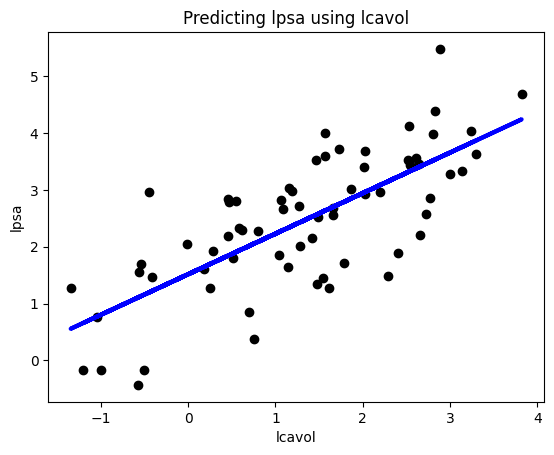

In [4]:
# Fit one feature
lr = linear_model.LinearRegression()
lr.fit(X_train[["lcavol"]], Y_train)

# plot the regression line over the training data
plt.scatter(X_train[["lcavol"]], Y_train, color="black")
plt.plot(
    X_train[["lcavol"]], lr.predict(X_train[["lcavol"]]), color="blue", linewidth=3
)
plt.title("Predicting lpsa using lcavol")
plt.xlabel("lcavol")
plt.ylabel("lpsa")

# report the R-squared value
r2 = lr.score(X_train[["lcavol"]], Y_train)
print("R-squared:", r2)

## Problem 2: Best Subset Feature Selection
Now we will look at finding the best subset of features out of all possible subsets.  To do this, you will implement the Best Feature Subset Selection.  We will break this into subproblems to walk through it.  To help you with this we have provided a function findsubsets(S,k).  When passed a set S this function will return a set of all subsets of size k, which you can iterate through to train models.

In [5]:
def findsubsets(S,k):
    return set(itertools.combinations(S, k))

### (a)
(8 points)
We will start by getting familiar with the findsubsets() function.  The variable 'features' was defined previously as a set of all feature names.  In the cell do the following:
* Use findsubsets to find all possible subsets of 3 features
* Perform 5-fold cross validation to train a LinearRegression model on each set of 3 features
* Find the model with the highest average $R^2$ score (scoring='r2')
* Report the best performing set of features and the corresponding $R^2$ score

[Documentation - Scikit-Learn - cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)


In [6]:
lr = linear_model.LinearRegression()

r2_means_subsets_3 = []
for combination in findsubsets(features, 3):
    mean_r2 = cross_val_score(
        lr, X_train[list(combination)], Y_train, scoring="r2", cv=5
    ).mean()
    r2_means_subsets_3.append((mean_r2, combination))

best_r2_subset_3, best_feature_combo = sorted(r2_means_subsets_3, key=lambda x: -x[0])[0]
print(
    f"Best-performing set of features: {best_feature_combo} (R-squared = {best_r2_subset_3})"
)

Best-performing set of features: ('lcavol', 'lbph', 'svi') (R-squared = 0.5077687763246395)


### (b)
(15 points)
Now, repeat the above process for all subsets of all sizes.  For each $k=1,\ldots,8$ find all possible subsets of $k$ features and evaluate a model on each set of features using 5-fold cross validation.  Report your findings as follows,
* Produce a scatterplot of $R^2$ values for every run with subset size on the horizontal axis, and $R^2$ on the vertical axis (label your plot axes/title)
* Find the best performing model overall and report the $R^2$ and features for that model


Best-performing set of features: ('lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45') (R-squared = 0.5095788538218258)


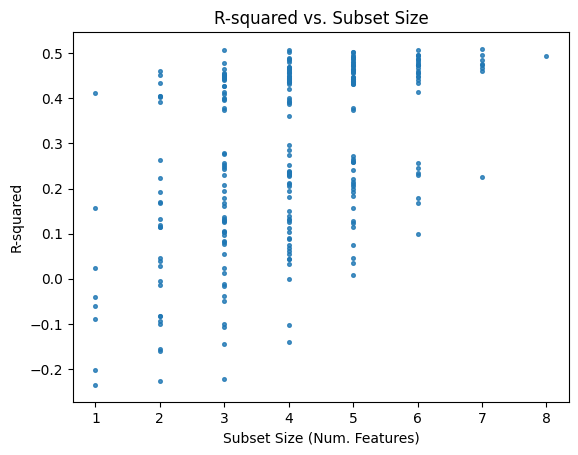

In [7]:
lr = linear_model.LinearRegression()

# evaluate all possible subsets of features
subset_sizes = []
r2_means_subsets_n = []
for k in range(1, 9):
    for combination in findsubsets(features, k):
        mean_r2 = cross_val_score(
            lr, X_train[list(combination)], Y_train, scoring="r2", cv=5
        ).mean()
        r2_means_subsets_n.append((mean_r2, combination))
        subset_sizes.append(k)

# plot the R-squared values vs. subset size
plt.scatter(subset_sizes, [r2 for r2, _ in r2_means_subsets_n], alpha=0.8, s=7)
plt.xlabel("Subset Size (Num. Features)")
plt.ylabel("R-squared")
plt.title("R-squared vs. Subset Size")

# report the best-performing subset of features
best_r2_subset_2, best_feature_combo = sorted(r2_means_subsets_n, key=lambda x: -x[0])[0]
print(
    f"Best-performing set of features: {best_feature_combo} (R-squared = {best_r2_subset_2})"
)

**Excellent**  You have found the best set of features by brute-force search over all possible features.  Good work.

## Problem 3 : Ridge Regression

### (a)
(5 points)
The problem with brute force search over features is that it doesn't scale well.  We can do it for 8 features, but we can't do it for larger sets of features.  Instead, we will look at a simpler model selection strategy by using L2 regularized linear regression (a.k.a. Ridge Regression).  Do the following in the cell below,
* Learn a Ridge regression model on training data with alpha=0.5
* Report the learned feature weights using the provided printFeatureWeights function

[Documentation - Scikit-Learn - linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [8]:
def printFeatureWeights(f, w):
    for idx in range(len(f)):
        print("%s : %f" % (f[idx], w[idx]))


reg_ridge = linear_model.Ridge(alpha=0.5)
reg_ridge.fit(X_train, Y_train)
printFeatureWeights(features, reg_ridge.coef_.flatten())

lcavol : 0.576706
lweight : 0.593447
age : -0.018544
lbph : 0.145617
svi : 0.683643
lcp : -0.193621
gleason : -0.034175
pgg45 : 0.009508


### (b)
(12 points)
We chose the regularization coefficient alpha=0.5 somewhat arbitrarily.  We now need to perform model selection in order to learn the best value of alpha.  We will do that by using cross_val_score over a range of values for alpha.  When searching for regularization parameters it is generally good practice to search in log-domain, rather than linear domain.  For example, we will search in the range $[10^{-1}, 10^3]$.  Using Numpy's "logspace" function this corresponds to the range $[-1, 3]$ in log-domain.  In the cell below do the following,
* Create a range of 50 alpha values spaced logarithmically in the range $[10^{-1}, 10^3]$
* Perform 5-fold cross-validation of Ridge regression model for each alpha and record $R^2$ score for each run (there will be 5x50 values)
* Report the best $R^2$ score and the value of alpha that achieves that score
* Use Matplotlib errorbar() function to plot the average $R^2$ with 1 standard deviation error bars for each of the 50 alpha values

[Documentation - Matplotlib - errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html)

[Documentation - Numpy - logspace](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html)

Best R²: 0.511, Best α: 2.947


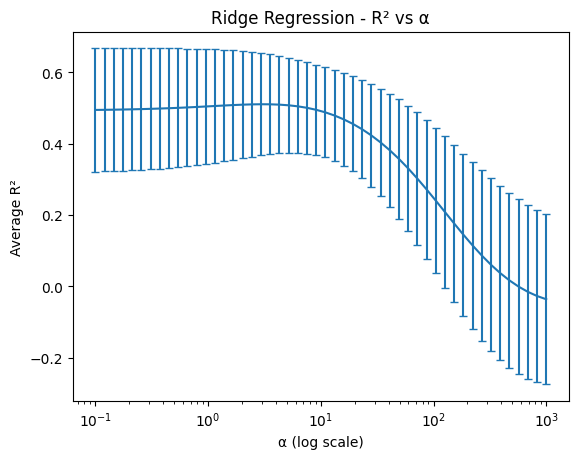

In [9]:
domain = np.logspace(-1, 3, 50)

# find the best alpha value across domain
r2_means_ridge, r2_stds_ridge = [], []
for alpha in domain:
    reg = linear_model.Ridge(alpha=alpha)
    r2_vals = cross_val_score(reg, X_train, Y_train, scoring="r2", cv=5)
    r2_means_ridge.append(r2_vals.mean())
    r2_stds_ridge.append(r2_vals.std())

# plot the R-squared values
plt.errorbar(domain, r2_means_ridge, yerr=r2_stds_ridge, fmt="-", capsize=3)
plt.xscale("log")
plt.title("Ridge Regression - R² vs α")
plt.xlabel("α (log scale)")
plt.ylabel("Average R²")

# report the best R-squared value and the corresponding alpha
best_r2_ridge = np.max(r2_means_ridge)
best_alpha_ridge = domain[np.argmax(r2_means_ridge)]
print(f"Best R²: {best_r2_ridge:.3f}, Best α: {best_alpha_ridge:.3f}")

Now that we have a good model we will look at what it has learned.  Train the Ridge regression model using the selected alpha from the previous cell.  Report the learned feature weights using the printFeatureWeights() function previously provided.

## Problem 4 : LASSO
Ridge regression performs shrinkage of the weights using the L2 norm.  This will drive some weights *close* to zero, but not exactly zero.  The LASSO method replaces the L2 penalty with an L1 penalty.  Due to properties of L1 discussed in lecture, this has the effect of learning exactly zero weights on some features when it is supported by the data.  In this problem we will repeat procedure of learning a Ridge regression model, but we will instead use LASSO.  Let's start by fitting a LASSO model with a fixed alpha value.  

### (a)
(5 points)
In the cell below do the following,
* Fit LASSO with alpha=0.1
* Use printFeatureWeights() to report the learned feature weights

[Documentation - Scikit-Learn - linear_model.Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)



In [10]:
reg_lasso = linear_model.Lasso(alpha=0.1)
reg_lasso.fit(X_train, Y_train)
printFeatureWeights(features, reg_lasso.coef_.flatten())

lcavol : 0.538986
lweight : 0.184891
age : -0.006352
lbph : 0.128433
svi : 0.000000
lcp : -0.000000
gleason : -0.000000
pgg45 : 0.007727


### (b)
(8 points)
Now we will find a good value of alpha using cross-validation.  Due to differences in how the LASSO model is optimized, there are dedicated methods for performing cross-validation on LASSO.  Scikit-Learn's LassoLarsCV class performs LASSO-specific cross-validation using an optimized [Least Angle Regression](https://en.wikipedia.org/wiki/Least-angle_regression) (LARS) algorithm.  In the cell below do the following,
* Using LassoLarsCV perform 20-fold cross validation to solve all solution paths for Lasso
* Plot mean +/- standard error of **mean squared error** versus regularization coefficient $\alpha$
* Title the plot and axes
* Report the best alpha value and the corresponding average mean squared error from cross-validation

Note: LassoLarsCV returns mean squared error, rather than $R^2$.  It also determines the set of $\alpha$ values automatically, which are stored in the cv_alphas_ attribute.

[Documentation - Scikit-Learn - LassoLarsCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsCV.html)

Best α: 0.0125 (MSE: 0.5858)


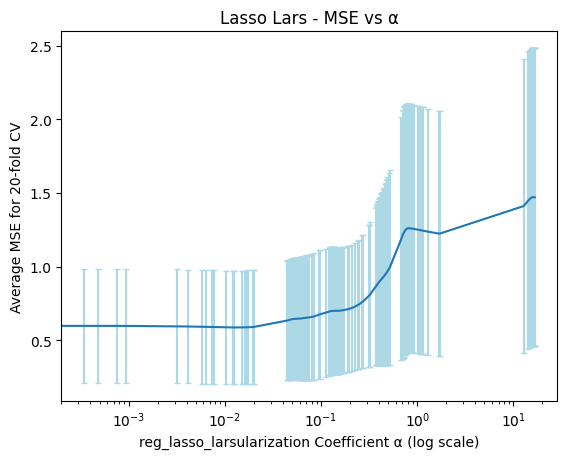

In [11]:
reg_lasso_lars = linear_model.LassoLarsCV(cv=20)
reg_lasso_lars.fit(X_train, Y_train)

# plot the MSE for each α value
plt.errorbar(
    reg_lasso_lars.cv_alphas_,  # = α values
    reg_lasso_lars.mse_path_.mean(axis=1),  # = mean of MSE for each α across 20 folds
    yerr=reg_lasso_lars.mse_path_.std(
        axis=1
    ),  # = standard deviation of MSE for each α across 20 folds
    fmt="-",
    capsize=2,
    ecolor="lightblue",
)
plt.xscale("log")
plt.title("Lasso Lars - MSE vs α")
plt.xlabel("reg_lasso_larsularization Coefficient α (log scale)")
plt.ylabel("Average MSE for 20-fold CV")

# report the best alpha and the corresponding MSE
best_alpha_lasso = reg_lasso_lars.alpha_
best_mse_lasso = reg_lasso_lars.mse_path_.mean(axis=1)[
    np.where(reg_lasso_lars.cv_alphas_ == best_alpha_lasso)
][0]
print(f"Best α: {best_alpha_lasso:.4f} (MSE: {best_mse_lasso:.4f})")

# highlight best alpha on plot
# plt.axvline(best_alpha_lasso, color="red", linestyle="--")
# plt.text(
#     best_alpha_lasso,
#     best_mse_lasso,
#     f"Best α: {best_alpha_lasso:.4f}",
#     rotation=90,
#     va="bottom",
#     ha="right",
# );

## Problem 5 : Evaluate on Test

In this problem we will train all of the best performing models chosen by Best Subsets, Ridge Regression, and LASSO.  We will evaluate and compare these models on the test data.  This dataset uses a standard train / test split so we begin by loading test data below.

In [12]:
# this assumes you have downloaded the test dataset to the My Drive/datasets folder.
df_test = pd.read_csv('/content/drive/My Drive/datasets/prostate_test.csv')
df_test = shuffle(df_test)
df_test.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
26,2.779440,3.823192,63,-1.386294,0,0.371564,7,50,3.513037
28,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124
0,0.737164,3.473518,64,0.615186,0,-1.386294,6,0,0.765468
20,1.997418,3.719651,63,1.619388,1,1.909542,7,40,2.853592
21,2.034706,3.917011,66,2.008214,1,2.110213,7,60,2.882004


### (a)
(5 points)
Recall that all of the data are stored in a single table, with the final column being the output 'lpsa'.  Before evaluating on test you must first create X_test and Y_test input/outputs where Y_test is the final column of the DataFrame, and X_test contains all other columns.

In [13]:
features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
output = ['lpsa']

X_test = df_test[features].copy()
Y_test = df_test[output].copy()

### (b) Best Subsets  
(8 points)
In Problem 2 you found the best subset of features for an ordinary least squares regression model by enumerating all feature subsets.  Using the best selected features train the model below and report mean squared error and $R^2$ on the test set.

In [14]:
# use best combination of features from previous step to fit the model
lr = linear_model.LinearRegression()
lr.fit(X_train[list(best_feature_combo)], Y_train)

# score the model's accuracy on the test data
r2_best_subsets = lr.score(X_test[list(best_feature_combo)], Y_test)
preds_best_subsets = lr.predict(X_test[list(best_feature_combo)])
mse_best_subsets = sklearn.metrics.mean_squared_error(Y_test, preds_best_subsets)

print(
    "Best Subsets:",
    f"Features Used: {best_feature_combo}",
    f"Coefficients: {lr.coef_}",
    f"MSE: {mse_best_subsets:.3f}",
    f"R²: {r2_best_subsets:.3f}\n",
    sep="\n\t",
)

# show an additional summary of the model
X_train_sm = sm.add_constant(X_train[list(best_feature_combo)])
model = sm.OLS(Y_train, X_train_sm).fit()
print(model.summary())

Best Subsets:
	Features Used: ('lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45')
	Coefficients: [[ 0.57393039  0.61920883 -0.01947988  0.14442647  0.74178126 -0.20541699
   0.008945  ]]
	MSE: 0.517
	R²: 0.508

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     19.14
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           4.50e-13
Time:                        03:39:39   Log-Likelihood:                -67.517
No. Observations:                  67   AIC:                             151.0
Df Residuals:                      59   BIC:                             168.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                 

### (c) Ridge Regression
(7 points)
In the cell below, train a Ridge Regression model using the optimal regularization coefficient ($\alpha$) found in Problem 3.  Report mean squared error and $R^2$ on the test set.

In [15]:
# use best alpha value from previous step to fit the model
reg_ridge = linear_model.Ridge(alpha=best_alpha_ridge)
reg_ridge.fit(X_train, Y_train)

# score the model's accuracy on the test data
r2_ridge = reg_ridge.score(X_test, Y_test)
preds_ridge = reg_ridge.predict(X_test)
mse_ridge = sklearn.metrics.mean_squared_error(Y_test, preds_ridge)

print(
    "Ridge Regression:",
    f"Coefficients:{reg_ridge.coef_}",
    f"alpha = {best_alpha_ridge:.3f}",
    f"MSE = {mse_ridge:.3f}",
    f"R² = {r2_ridge:.3f}",
    sep="\n\t",
)

Ridge Regression:
	Coefficients:[[ 0.56922528  0.50983485 -0.01665626  0.14982882  0.51047465 -0.14608895
  -0.0451706   0.00952581]]
	alpha = 2.947
	MSE = 0.523
	R² = 0.501


### (d) LASSO Regression
(7 points)
Now, train and evaluate your final model.  Train a Lasso regression using the optimal $\alpha$ parameters from Problem 4 and report MSE and $R^2$ on the test set.

In [16]:
# use the optimal regularization coefficient from the previous step to fit the model
reg_lasso = linear_model.Lasso(alpha=best_alpha_lasso)
reg_lasso.fit(X_train, Y_train)

# score the model's accuracy on the test data
r2_lasso = reg_lasso.score(X_test, Y_test)
preds_lasso = reg_lasso.predict(X_test)
mse_lasso = sklearn.metrics.mean_squared_error(preds_lasso, Y_test)

print(
    "Lasso Regression:",
    f"Coefficients:{reg_lasso.coef_}",
    f"alpha = {reg_lasso.alpha}",
    f"MSE = {mse_lasso:.3f}",
    f"R² = {r2_lasso:.3f}",
    sep="\n\t",
)

Lasso Regression:
	Coefficients:[ 0.56554452  0.56815305 -0.01771631  0.14165302  0.59871033 -0.15855654
 -0.          0.0085379 ]
	alpha = 0.012451744414297677
	MSE = 0.507
	R² = 0.517


### (e) Compare feature weights for each model
(8 points)
Now let's compare the feature weight learned by each of the three models.  In the cell below, report the regression weights for each feature under Best Subset, Ridge, and Lasso models evaluated above.  To make the output easier to read, please use a Pandas DataFrame to display the data.  To do this, create a Pandas DataFrame where each column contains regression weights for one of the previous models, and then display that DataFrame in the standard fashion.  You should also provide feature names on each of the rows.

[Documentation - Pandas - DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [17]:
model_names = ["Best Subset Regression", "Ridge Regression", "Lasso Regression"]
results_df = pd.DataFrame(
    columns=model_names, index=features
)

for i, feature in enumerate(features):
    results_df.loc[feature] = [
        (
            lr.coef_[0][list(best_feature_combo).index(feature)]
            if feature in best_feature_combo
            else 0
        ),
        reg_ridge.coef_[0][i],
        reg_lasso.coef_[i],
    ]

# create another table comparing metrics
# metrics_df = pd.DataFrame(
#     columns=model_names, index=["MSE", "R²"]
# )
# metrics_df.loc["MSE"] = [mse_best_subsets, mse_ridge, mse_lasso]
# metrics_df.loc["R²"] = [r2_best_subsets, r2_ridge, r2_lasso]
# print("Model performance metrics:")
# print(metrics_df)

print("\n\nModel Feature weights:")
results_df



Model Feature weights:


,Best Subset Regression,Ridge Regression,Lasso Regression
lcavol,0.57393,0.569225,0.565545
lweight,0.619209,0.509835,0.568153
age,-0.01948,-0.016656,-0.017716
lbph,0.144426,0.149829,0.141653
svi,0.741781,0.510475,0.59871
lcp,-0.205417,-0.146089,-0.158557
gleason,0,-0.045171,-0.0
pgg45,0.008945,0.009526,0.008538
